# Investment Portfolio Analysis

**Author:** Luis Santamaría  
**Date:** January 7, 2025
---

## Objective  
The goal of this project is to build a **clean, analysis-ready universe of equities** drawn from the S&P 500 (U.S.), S&P/BMV IPC (Mexico), and Ibovespa (Brazil), then evaluate portfolio behavior over the last five years. Specifically, we will:  
- Normalize tickers to Yahoo Finance symbols, fetch prices/metadata, and pass quality checks.  
- Construct daily return matrices and aggregate statistics.  
- Compute and visualize the **efficient frontier** (including minimum-variance, tangency, and maximum-variance portfolios), along with historical performance metrics (return, volatility, Sharpe, drawdowns).  

This work provides a reproducible **backend pipeline** for robust portfolio research and a foundation for a later **Streamlit** app.  

---

## Research Questions  
1. Which assets pass strict data-quality filters (coverage, freshness, NaNs, variance) across S&P 500, IPC, and Ibovespa?  
2. How do risk/return characteristics differ by index and (implicitly) by currency/market?  
3. What does the efficient frontier look like for each region and for combined universes?  
4. How do the minimum-variance and tangency portfolios perform in-sample over the past five years?  
5. How sensitive are the results to data cleaning thresholds and rebalancing assumptions?  

---

## Working Hypotheses  
- **Diversification benefit:** A mixed universe (U.S., Mexico, Brazil) should improve the frontier relative to single-market sets.  
- **FX impact:** Ignoring currency conversion may distort cross-market comparisons; converting to a base currency should change rankings and Sharpe ratios.  
- **Data quality matters:** Stricter QC (coverage, freshness, NaNs) will shrink the universe but yield more stable estimates (covariances, expected returns).  
- **Risk concentration:** Minimum-variance portfolios will tilt toward lower-beta, higher-liquidity names; tangency portfolios may concentrate in segments with stronger momentum/Sharpe.  

---

## Scope and Limitations (Data Card)  
- **Data sources:**  
  - Constituents: public index pages (S&P 500, S&P/BMV IPC, Ibovespa).  
  - Prices/metadata: Yahoo Finance (daily, ~5 years).  
- **Coverage period:** ~5 years up to the present date (rolling window).  
- **Expected fields:**  
  - **Universe:** `symbol_raw, name, sector (if available), index, yahoo, currency, exchange`  
  - **Prices:** `date, Close, AdjClose, Volume`  
  - **Derived:** daily returns, annualized stats, covariance matrices  
- **Scope:** In-sample analysis with **static weights** for frontier construction; no transaction costs or taxes; no intraday data.  
- **Limitations:**  
  - **Survivorship bias:** Current constituents may exclude delisted names.  
  - **Corporate actions:** Splits/dividends rely on vendor adjustments (possible discrepancies).  
  - **Staleness & holidays:** Different trading calendars and missing days across markets.  
  - **FX conversion:** If metrics are mixed-currency without conversion, cross-market comparisons are imperfect.  
  - **Parameter uncertainty:** Mean/covariance estimates over 5Y are noisy; results are sensitive to estimation choices.  

*These constraints should be considered when interpreting efficient-frontier shapes and portfolio rankings.*  

## 1. Project Setup and Index Constituents  

In this first section we prepare the project environment and gather the raw list of companies that will form the initial investment universe. The goal is to establish a **reliable starting point** before moving to price data and portfolio analysis.  

We begin by creating a simple folder structure where we will store different types of data such as raw index constituents, cleaned universes, and historical prices. This ensures that all subsequent steps can read and write data in an organized way.  

After the folders are ready, we fetch the **constituents of three major indices**: the S&P 500 in the U.S., the S&P/BMV IPC in Mexico, and the Ibovespa in Brazil. For each index we collect the company symbol and name, and where available, the sector. This step relies on publicly available information (Wikipedia pages), which provides a reproducible and transparent source.  

Once the data from all three indices is collected, we merge them into a single dataset. We also apply a minimal cleaning routine: removing spaces, converting symbols to uppercase, and handling common quirks such as asterisks that appear in some Mexican tickers. Finally, we save the combined list as `data/raw/constituents_raw.csv`.  

At the end of this section, we will have a consolidated file with the raw universe of potential assets. This file will serve as the basis for further processing, such as ticker normalization to Yahoo Finance symbols and subsequent data quality checks.

In [13]:
# ======================= Step 1: Build Constituents (final) =======================
from pathlib import Path
import time, re, copy
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from io import StringIO

# ---------------------- Folders ----------------------
BASE = Path(".").resolve()
DATA = BASE / "data"
RAW = DATA / "raw"
PRICES = DATA / "prices"
UNIVERSES = DATA / "universes"
for p in [DATA, RAW, PRICES, UNIVERSES]:
    p.mkdir(parents=True, exist_ok=True)

print("Folders ready:")
for p in [DATA, RAW, PRICES, UNIVERSES]:
    print(" -", p)

# ---------------------- HTTP helpers -----------------
HDRS = {
    "User-Agent": (
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
        "AppleWebKit/537.36 (KHTML, like Gecko) "
        "Chrome/122.0.0.0 Safari/537.36"
    ),
    "Accept-Language": "es-ES,es;q=0.9,en-US;q=0.8,en;q=0.7",
}
def fetch_html(url: str, retries: int = 4, backoff: float = 1.5) -> str:
    last_exc = None
    for i in range(retries):
        try:
            r = requests.get(url, headers=HDRS, timeout=25)
            if r.status_code == 200 and r.text:
                return r.text
            last_exc = RuntimeError(f"HTTP {r.status_code} for {url}")
        except Exception as e:
            last_exc = e
        time.sleep(backoff * (i + 1))
    raise last_exc if last_exc else RuntimeError(f"Failed to fetch {url}")

def _clean_text(x: str) -> str:
    if not x: return ""
    return re.sub(r"\s+", " ", str(x)).replace("\xa0"," ").strip()

# ---------------------- Validators -------------------
MX_TICKER_RE = re.compile(r"^[A-Z0-9\-\.\*]{1,16}$")
def _clean_symbol(s: str) -> str:
    if s is None: return ""
    s = _clean_text(s).upper()
    s = re.sub(r"\[[0-9]+\]", "", s)           # remove [1],[2] refs
    s = re.sub(r"[¹²³⁴⁵⁶⁷⁸⁹⁰]", "", s)        # remove superscript digits
    s = re.sub(r"[^A-Z0-9\-\.\*]", "", s)      # allow only valid chars
    return s.strip()

# ---------------------- SP500 (Wikipedia EN) ---------
def sp500_constituents() -> pd.DataFrame:
    url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
    html = fetch_html(url)
    tables = pd.read_html(StringIO(html), flavor="bs4")
    df = tables[0].copy()
    df = df.rename(columns={"Symbol":"symbol","Security":"name"})
    df = df[["symbol","name"]].copy()
    df["symbol"] = df["symbol"].astype(str).str.strip().str.upper()
    df["name"] = df["name"].astype(str).str.strip()
    df["index"] = "SP500"
    return df[["symbol","name","index"]]

# ---------------------- IPC (Wikipedia ES) -----------
URL_IPC_WIKI_ES = "https://es.wikipedia.org/wiki/%C3%8Dndice_de_Precios_y_Cotizaciones"

def ipc_constituents() -> pd.DataFrame:
    html = fetch_html(URL_IPC_WIKI_ES)
    soup = BeautifulSoup(html, "lxml")
    tables = soup.select("table.wikitable")

    symbols, names = [], []
    for tbl in tables:
        ths = [_clean_text(th.get_text(" ", strip=True)).lower() for th in tbl.find_all("th")]
        if not any("símbolo" in h or "simbolo" in h or "symbol" in h for h in ths):
            continue
        for tr in tbl.find_all("tr"):
            tds = tr.find_all("td")
            if len(tds) < 2:
                continue
            # clean symbol cell
            sym_td = copy.copy(tds[0])
            for sup in sym_td.find_all("sup"): sup.decompose()
            for ref in sym_td.find_all("span", class_=re.compile("reference")): ref.decompose()
            raw_sym = _clean_text(sym_td.get_text(" ", strip=True))
            sym = _clean_symbol(raw_sym)
            if not sym or not MX_TICKER_RE.match(sym):
                continue
            # clean name cell
            name_td = copy.copy(tds[1])
            for sup in name_td.find_all("sup"): sup.decompose()
            nm = _clean_text(name_td.get_text(" ", strip=True))
            if not nm or nm in {"—","--","-"}:
                continue
            symbols.append(sym)
            names.append(nm)
    df = pd.DataFrame({"symbol": symbols, "name": names})
    df = df.drop_duplicates(subset=["symbol"]).reset_index(drop=True)
    # drop header row accidentally parsed (usually "Símbolo"/"Empresa")
    df = df[df["symbol"]!="SÍMBOLO"]
    df["index"] = "IPC"
    return df[["symbol","name","index"]]

# ---------------------- IBOV (TradingView) -----------
TV_HREF_RE = re.compile(r"^/symbols/([A-Z]+)-([A-Z0-9.\-\*]+)/?$")
def _is_ticker_br(s: str) -> bool:
    if not isinstance(s,str): return False
    s = s.strip().upper()
    return bool(re.fullmatch(r"[A-Z]{3,6}[0-9]{1,2}", s))

def ibov_constituents() -> pd.DataFrame:
    url = "https://es.tradingview.com/symbols/BMFBOVESPA-IBOV/components/"
    html = fetch_html(url)
    soup = BeautifulSoup(html, "lxml")
    table = soup.select_one("table[class*='tv-data-table']")
    rows = table.find("tbody").find_all("tr") if table and table.find("tbody") else soup.find_all("tr")

    symbols, names = [], []
    for tr in rows:
        a = None; symbol=None
        for cand in tr.find_all("a", href=True):
            m = TV_HREF_RE.match(cand["href"])
            if not m: continue
            _, sym = m.groups()
            if sym in {"IBOV"}: continue
            if _is_ticker_br(sym):
                symbol = sym.upper().strip(); break
        if not symbol: continue
        tds = tr.find_all("td")
        nm = _clean_text(tds[0].get_text(" ", strip=True)) if tds else ""
        nm = re.sub(rf"\b{re.escape(symbol)}\b"," ",nm,flags=re.I).strip()
        if not nm: nm = np.nan
        symbols.append(symbol); names.append(nm)
    df = pd.DataFrame({"symbol":symbols,"name":names}).drop_duplicates(subset=["symbol"]).reset_index(drop=True)
    df["index"]="IBOV"
    return df[["symbol","name","index"]]

# ---------------------- Merge & Save -----------------
sp = sp500_constituents()
ipc = ipc_constituents()
ibov = ibov_constituents()

final_df = pd.concat([sp, ipc, ibov], ignore_index=True)

# Fallback: si name falta, usar symbol
final_df["name"] = final_df.apply(
    lambda r: r["symbol"] if (pd.isna(r["name"]) or str(r["name"]).strip()=="") else str(r["name"]).strip(),
    axis=1
)

final_df = final_df[["symbol","name","index"]].drop_duplicates().reset_index(drop=True)

out_csv = RAW / "constituents_clean.csv"
final_df.to_csv(out_csv, index=False, encoding="utf-8")

print(f"\nSaved: {out_csv}")
print("\nCounts by index:")
print(final_df.groupby("index")["symbol"].count())

print("\nSamples:")
for idx in ["SP500","IPC","IBOV"]:
    print(f"\n{idx} — sample:")
    display(final_df[final_df["index"]==idx].head(10))



Folders ready:
 - /content/data
 - /content/data/raw
 - /content/data/prices
 - /content/data/universes

Saved: /content/data/raw/constituents_clean.csv

Counts by index:
index
IBOV      83
IPC       36
SP500    503
Name: symbol, dtype: int64

Samples:

SP500 — sample:


,symbol,name,index
0,MMM,3M,SP500
1,AOS,A. O. Smith,SP500
2,ABT,Abbott Laboratories,SP500
3,ABBV,AbbVie,SP500
4,ACN,Accenture,SP500
5,ADBE,Adobe Inc.,SP500
6,AMD,Advanced Micro Devices,SP500
7,AES,AES Corporation,SP500
8,AFL,Aflac,SP500
9,A,Agilent Technologies,SP500



IPC — sample:


,symbol,name,index
503,AMXL,América Móvil,IPC
504,WALMEXV,Walmex,IPC
505,FEMSAUBD,Fomento Económico Mexicano,IPC
506,TLEVISACPO,Grupo Televisa,IPC
507,GMEXICOB,Grupo México,IPC
508,GFNORTEO,Grupo Financiero Banorte,IPC
509,CEMEXCPO,Cemex,IPC
510,ALFAA,Grupo Alfa,IPC
511,PEOLES,Industrias Peñoles,IPC
512,GFINBURO,Grupo Financiero Inbursa,IPC



IBOV — sample:


,symbol,name,index
539,PETR4,Petroleo Brasileiro SA Pfd P,IBOV
540,PETR3,Petroleo Brasileiro SA,IBOV
541,ITUB4,Itau Unibanco Holding SA Pfd P,IBOV
542,VALE3,Vale S.A.,IBOV
543,ABEV3,Ambev SA,IBOV
544,BBDC3,Banco Bradesco SA,IBOV
545,BBDC4,Banco Bradesco SA Pfd P,IBOV
546,WEGE3,WEG SA,IBOV
547,ITSA4,Itausa SA Non-Cum Perp Pfd Registered Shs P,IBOV
548,BBAS3,Banco do Brasil S.A.,IBOV


## 2. Ticker Normalization to Yahoo Finance  

At this point we already have a clean universe of companies drawn from the three indices. The next challenge is that each market uses its own local ticker formats, while our price source, Yahoo Finance, expects a standardized syntax. If we try to query the raw symbols directly, many will fail. To bridge this gap, we translate each ticker into the version that Yahoo Finance recognizes. For the S&P 500 constituents this is simple, since their tickers remain unchanged. In the case of the Mexican IPC, we need to remove any asterisks that appear at the end of the symbol and add the suffix `.MX`. For Brazil’s Ibovespa, we add the suffix `.SA` to each symbol.  

Once this mapping is complete, we perform a light validation step to confirm that the translated tickers actually return data. We do this by fetching a short three-month window of prices, just to ensure the symbol is recognized and active. If the data comes back empty, we flag the ticker as having no price data. If the data exists but has not been updated in a long time, we mark it as stale. Otherwise, the ticker is validated as usable. This validation is not meant to be exhaustive, but it gives us confidence that the symbols we carry forward are reliable.  

The result of this process is a consolidated file that contains the original symbol, the company name, the index it belongs to, the translated Yahoo Finance ticker, and a status field describing whether the mapping is healthy. With this in place, we now have a dependable bridge between our constituent universe and the data provider we will use to build the portfolio analysis in the next steps.

In [14]:
# ========================== Step 2: Ticker Normalization ==========================
from pathlib import Path
import pandas as pd
import numpy as np
from datetime import datetime, timezone
import warnings

# Keep the notebook clean
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Optional quick validation using yfinance
try:
    import yfinance as yf
    YF_AVAILABLE = True
except Exception:
    YF_AVAILABLE = False

# --- Config -----------------------------------------------------------------
BASE = Path(".").resolve()
RAW = BASE / "data" / "raw"
INPUT_CSV = RAW / "constituents_clean.csv"
OUTPUT_CSV = RAW / "constituents_with_yahoo.csv"

# Toggle this to skip the quick network validation (faster/quiet)
VALIDATE = True and YF_AVAILABLE

# --- Load input --------------------------------------------------------------
assert INPUT_CSV.exists(), f"Missing file: {INPUT_CSV}. Run Step 1 first."
df = pd.read_csv(INPUT_CSV, dtype={"symbol":"string","name":"string","index":"string"})

# Normalize basic fields
df["symbol"] = df["symbol"].str.strip().str.upper()
df["index"]  = df["index"].str.strip().str.upper()
df["name"]   = df["name"].fillna("").astype(str).str.strip()
# If any name is still empty, backfill with the ticker (your rule)
df.loc[df["name"] == "", "name"] = df["symbol"]

# --- Mapping rules to Yahoo --------------------------------------------------
def to_yahoo(symbol: str, index_code: str) -> str:
    s = (symbol or "").strip().upper()
    idx = (index_code or "").strip().upper()
    if idx == "SP500":
        return s
    if idx == "IPC":   # Mexico
        s = s.replace("*", "")  # drop asterisk if present
        return f"{s}.MX"
    if idx == "IBOV":  # Brazil
        return f"{s}.SA"
    return s

df["yahoo"] = df.apply(lambda r: to_yahoo(r["symbol"], r["index"]), axis=1)

# --- Quick validation (lightweight; 3 months history) -----------------------
def quick_validate_yahoo(ticker: str) -> str:
    if not YF_AVAILABLE or not VALIDATE:
        return "unknown"
    try:
        tk = yf.Ticker(ticker)
        hist = tk.history(period="3mo", auto_adjust=False)
        if hist is None or hist.empty:
            return "no_price_data"
        # Last datapoint freshness check (UTC-aware)
        last_dt = pd.to_datetime(hist.index.max())
        # Some yfinance indices are tz-aware; normalize to naive date for comparison
        if getattr(last_dt, "tzinfo", None) is not None:
            last_dt = last_dt.tz_convert("UTC").tz_localize(None)
        if (datetime.now(timezone.utc).date() - last_dt.date()).days > 30:
            return "stale_data"
        return "ok"
    except Exception as e:
        return f"error:{type(e).__name__}"

if VALIDATE:
    print("Validating Yahoo symbols (quick check)…")
    df["status"] = df["yahoo"].map(quick_validate_yahoo)
else:
    df["status"] = "unknown"

# --- Persist & summarize -----------------------------------------------------
out = df[["symbol","name","index","yahoo","status"]].drop_duplicates().reset_index(drop=True)
out.to_csv(OUTPUT_CSV, index=False, encoding="utf-8")

print(f"Saved: {OUTPUT_CSV}")
print("\nValidation summary (counts):")
summary = out.groupby(["index","status"])["symbol"].count().unstack(fill_value=0)
print(summary)

print("\nSamples per index:")
for idx in ["SP500","IPC","IBOV"]:
    sub = out[out["index"]==idx][["symbol","name","yahoo","status"]].head(10)
    print(f"\n{idx}:")
    display(sub)

Validating Yahoo symbols (quick check)…


ERROR:yfinance:$BRK.B: possibly delisted; no price data found  (period=3mo) (Yahoo error = "No data found, symbol may be delisted")
ERROR:yfinance:$BF.B: possibly delisted; no price data found  (period=3mo)
ERROR:yfinance:$AMXL.MX: possibly delisted; no price data found  (period=3mo) (Yahoo error = "No data found, symbol may be delisted")
ERROR:yfinance:$WALMEXV.MX: possibly delisted; no price data found  (period=3mo)
ERROR:yfinance:$PEOLES.MX: possibly delisted; no price data found  (period=3mo) (Yahoo error = "No data found, symbol may be delisted")
ERROR:yfinance:$KOFL.MX: possibly delisted; no price data found  (period=3mo) (Yahoo error = "No data found, symbol may be delisted")
ERROR:yfinance:$MEXCHEM.MX: possibly delisted; no price data found  (period=3mo) (Yahoo error = "No data found, symbol may be delisted")
ERROR:yfinance:$KIMBER.MX: possibly delisted; no price data found  (period=3mo) (Yahoo error = "No data found, symbol may be delisted")
ERROR:yfinance:$COMPARC.MX: possibl

Saved: /content/data/raw/constituents_with_yahoo.csv

Validation summary (counts):
status  no_price_data   ok
index                     
IBOV                0   83
IPC                13   23
SP500               2  501

Samples per index:

SP500:


,symbol,name,yahoo,status
0,MMM,3M,MMM,ok
1,AOS,A. O. Smith,AOS,ok
2,ABT,Abbott Laboratories,ABT,ok
3,ABBV,AbbVie,ABBV,ok
4,ACN,Accenture,ACN,ok
5,ADBE,Adobe Inc.,ADBE,ok
6,AMD,Advanced Micro Devices,AMD,ok
7,AES,AES Corporation,AES,ok
8,AFL,Aflac,AFL,ok
9,A,Agilent Technologies,A,ok



IPC:


,symbol,name,yahoo,status
503,AMXL,América Móvil,AMXL.MX,no_price_data
504,WALMEXV,Walmex,WALMEXV.MX,no_price_data
505,FEMSAUBD,Fomento Económico Mexicano,FEMSAUBD.MX,ok
506,TLEVISACPO,Grupo Televisa,TLEVISACPO.MX,ok
507,GMEXICOB,Grupo México,GMEXICOB.MX,ok
508,GFNORTEO,Grupo Financiero Banorte,GFNORTEO.MX,ok
509,CEMEXCPO,Cemex,CEMEXCPO.MX,ok
510,ALFAA,Grupo Alfa,ALFAA.MX,ok
511,PEOLES,Industrias Peñoles,PEOLES.MX,no_price_data
512,GFINBURO,Grupo Financiero Inbursa,GFINBURO.MX,ok



IBOV:


,symbol,name,yahoo,status
539,PETR4,Petroleo Brasileiro SA Pfd P,PETR4.SA,ok
540,PETR3,Petroleo Brasileiro SA,PETR3.SA,ok
541,ITUB4,Itau Unibanco Holding SA Pfd P,ITUB4.SA,ok
542,VALE3,Vale S.A.,VALE3.SA,ok
543,ABEV3,Ambev SA,ABEV3.SA,ok
544,BBDC3,Banco Bradesco SA,BBDC3.SA,ok
545,BBDC4,Banco Bradesco SA Pfd P,BBDC4.SA,ok
546,WEGE3,WEG SA,WEGE3.SA,ok
547,ITSA4,Itausa SA Non-Cum Perp Pfd Registered Shs P,ITSA4.SA,ok
548,BBAS3,Banco do Brasil S.A.,BBAS3.SA,ok


## 3. Live Price Fetching (On-Demand, Dashboard-Ready)

Up to this point, we focused on building the investment universes and validating which tickers were available in Yahoo Finance. But a portfolio analysis is only as good as the quality and freshness of its price data. Instead of downloading years of history in advance—risking working with outdated numbers—we now switch to an **on-demand approach**.  

The logic is simple: whenever the user selects a group of tickers, we call Yahoo Finance directly, pull their latest prices, and normalize them into a consistent format. To avoid overloading the API and to keep performance smooth, we store results in a lightweight cache that expires after a few hours. This means that if the same request happens multiple times within a session, it is served instantly from disk; if the cache is stale, it gets refreshed seamlessly.  

To demonstrate this mechanism inside the notebook, we created a small **smoke test**. Each time the cell runs, it randomly selects an index (SP500, IPC, or IBOV) and then samples three tickers from that universe. Their prices are fetched for the past year and displayed in two views: a wide table (dates as rows, tickers as columns) and a long table (tidy format, ready for statistical operations).  

This setup mirrors exactly what the Streamlit dashboard will do, ensuring that the analysis you see there is always based on **fresh, real-market prices** instead of static snapshots.

In [49]:
# =================== Step 3: Live Price Fetching (TTL cache w/ horizon + 5-ticker session) ===================
from pathlib import Path
from datetime import datetime, timedelta, timezone
from typing import Iterable, Dict, Tuple
import json
import logging
import warnings

import pandas as pd
import numpy as np

# Keep the notebook quiet
warnings.filterwarnings("ignore", category=DeprecationWarning)
logging.getLogger("yfinance").setLevel(logging.CRITICAL)

# Live source
try:
    import yfinance as yf
    YF_AVAILABLE = True
except Exception:
    YF_AVAILABLE = False

# ---------------------------- Paths & settings ----------------------------
BASE = Path(".").resolve()
DATA = BASE / "data"
RAW = DATA / "raw"
CACHE = DATA / "prices_cache"
SESSION = DATA / "session"          # store last chosen universe (index + tickers)
for p in [DATA, RAW, CACHE, SESSION]:
    p.mkdir(parents=True, exist_ok=True)

LAST_UNIVERSE_JSON = SESSION / "last_universe.json"

CACHE_TTL_HOURS = 6          # refresh after this many hours
DEFAULT_LOOKBACK_YEARS = 5   # app default; smoke test uses 1y
DEFAULT_INTERVAL = "1d"

# ---------------------------- Cache helpers (HORIZON-AWARE) ----------------------------
def _utc_now() -> datetime:
    return datetime.now(timezone.utc)

def _cache_paths(ticker: str, interval: str, years: int) -> Tuple[Path, Path]:
    safe = ticker.replace("/", "_")
    # include horizon to avoid reusing a shorter snapshot (e.g., 1y) when 5y is requested
    return (
        CACHE / f"{safe}__{interval}__{int(years)}y.parquet",
        CACHE / f"{safe}__{interval}__{int(years)}y.json",
    )

def _cache_fresh(meta_path: Path, ttl_hours: int, min_years: int | None = None) -> bool:
    if not meta_path.exists():
        return False
    try:
        meta = json.loads(meta_path.read_text(encoding="utf-8"))
        ts = datetime.fromisoformat(meta.get("fetched_at"))
        if ts.tzinfo is None:
            ts = ts.replace(tzinfo=timezone.utc)
        fresh = (_utc_now() - ts) <= timedelta(hours=ttl_hours)
        if min_years is not None and int(meta.get("years", 0)) < int(min_years):
            return False
        return fresh
    except Exception:
        return False

def _cache_read(ticker: str, interval: str, years: int) -> pd.DataFrame | None:
    data_path, meta_path = _cache_paths(ticker, interval, years)
    if data_path.exists() and _cache_fresh(meta_path, CACHE_TTL_HOURS, min_years=years):
        try:
            df = pd.read_parquet(data_path)
            if not df.empty:
                return df
        except Exception:
            return None
    return None

def _cache_write(ticker: str, interval: str, years: int, df: pd.DataFrame) -> None:
    data_path, meta_path = _cache_paths(ticker, interval, years)
    try:
        df.to_parquet(data_path, index=True)
        meta = {"fetched_at": _utc_now().isoformat(), "years": int(years), "interval": interval}
        meta_path.write_text(json.dumps(meta), encoding="utf-8")
    except Exception:
        pass  # best-effort

# ---------------------------- Normalization -----------------------------------
def _normalize_history(df_raw: pd.DataFrame) -> pd.DataFrame:
    """Normalize yfinance history into a standard schema."""
    if df_raw is None or df_raw.empty:
        return pd.DataFrame()
    df = df_raw.copy()
    idx = pd.to_datetime(df.index)
    if getattr(idx, "tz", None) is not None:
        idx = idx.tz_convert("UTC").tz_localize(None)
    df.index = idx

    cols = {c.lower(): c for c in df.columns}
    out = pd.DataFrame(index=df.index)
    out["close"] = df[cols.get("close", "Close")] if ("close" in cols or "Close" in df.columns) else np.nan
    adj_col = cols.get("adj close") or cols.get("adjclose") or ("Adj Close" if "Adj Close" in df.columns else None)
    out["adj_close"] = df[adj_col] if adj_col else out["close"]
    vol_col = cols.get("volume") or ("Volume" if "Volume" in df.columns else None)
    out["volume"] = df[vol_col] if vol_col else np.nan

    out = out.sort_index().loc[~out.index.duplicated(keep="last")]
    return out.dropna(how="all")

# ---------------------------- Public API --------------------------------------
def fetch_prices_live(
    ticker: str,
    years: int = DEFAULT_LOOKBACK_YEARS,
    interval: str = DEFAULT_INTERVAL,
    use_cache: bool = True
) -> pd.DataFrame:
    """
    Fetch up-to-date prices for a single ticker from Yahoo Finance.
    Returns a DataFrame with columns: close, adj_close, volume; datetime index (UTC-naive).
    """
    if use_cache:
        cached = _cache_read(ticker, interval, years)
        if cached is not None:
            return cached

    if not YF_AVAILABLE:
        raise RuntimeError("yfinance is not available in this environment.")

    end_dt = _utc_now()
    start_dt = end_dt - timedelta(days=365 * years + 7)

    tk = yf.Ticker(ticker)
    df_raw = tk.history(start=start_dt.date(), end=None, interval=interval, auto_adjust=False)
    df = _normalize_history(df_raw)

    # fallback (calendar quirks)
    if df.empty:
        df_raw = tk.history(period=f"{max(1, years)}y", interval=interval, auto_adjust=False)
        df = _normalize_history(df_raw)

    if df.empty:
        raise RuntimeError(f"No price data for {ticker}")

    if use_cache:
        _cache_write(ticker, interval, years, df)

    return df

def get_prices_on_demand(
    tickers: Iterable[str],
    years: int = DEFAULT_LOOKBACK_YEARS,
    interval: str = DEFAULT_INTERVAL,
    use_cache: bool = True
) -> tuple[pd.DataFrame, pd.DataFrame, Dict[str, str]]:
    """
    Batch fetch for many tickers.
      Returns:
        - wide_df: (dates x tickers) adj_close matrix
        - long_df: tidy with [ticker, date, adj_close, close, volume]
        - errors: dict of ticker -> reason
    """
    wide_cols = []
    long_rows = []
    errors: Dict[str, str] = {}

    for t in tickers:
        try:
            df = fetch_prices_live(t, years=years, interval=interval, use_cache=use_cache)

            # Wide
            wide_cols.append(df["adj_close"].rename(t))

            # Long (robust 'date' creation)
            tmp = df.copy()
            dates = pd.to_datetime(tmp.index).tz_localize(None)
            tmp = tmp.assign(date=dates, ticker=t).reset_index(drop=True)
            for col in ["adj_close", "close", "volume"]:
                if col not in tmp.columns:
                    tmp[col] = np.nan
            long_rows.append(tmp[["ticker", "date", "adj_close", "close", "volume"]])

        except Exception as e:
            errors[t] = str(e)

    wide_df = pd.concat(wide_cols, axis=1) if wide_cols else pd.DataFrame()
    if not wide_df.empty:
        wide_df = wide_df.sort_index().dropna(axis=1, how="all")

    long_df = pd.concat(long_rows, axis=0, ignore_index=True) if long_rows else pd.DataFrame()
    if not long_df.empty:
        long_df["date"] = pd.to_datetime(long_df["date"]).dt.tz_localize(None)

    return wide_df, long_df, errors

# ---------------------------- Session universe: exactly 5 tickers ----------------------------
# Pick a random index with >=5 tickers; then randomly sample EXACTLY five from that index.
ok_all = (
    pd.read_csv(RAW / "constituents_with_yahoo.csv")
      .query("status == 'ok'")
      .dropna(subset=["yahoo"])
)

if ok_all.empty:
    print("Smoke test skipped: no tickers with status == 'ok'.")
else:
    counts = ok_all.groupby(ok_all["index"].str.upper())["yahoo"].nunique()
    candidates = counts[counts >= 5].index.tolist()

    rng = np.random.default_rng()  # new randomness each run

    if candidates:
        chosen_index = rng.choice(candidates)
    else:
        # Fallback: pick the index with the most tickers; if <5, take as many as possible but ≤5
        chosen_index = counts.sort_values(ascending=False).index[0]

    pool = ok_all[ok_all["index"].str.upper() == chosen_index]["yahoo"].unique().tolist()
    sample_n = min(5, len(pool))
    if sample_n < 2:
        print(f"Smoke test skipped: not enough usable tickers in {chosen_index}.")
    else:
        tickers = rng.choice(pool, size=sample_n, replace=False).tolist()

        print(f"Smoke test — index: {chosen_index} | tickers: {tickers}")
        wide, long, errs = get_prices_on_demand(tickers, years=1, interval="1d", use_cache=True)
        if errs:
            print("Non-fatal fetch errors:", errs)
        print("\nWide (tail):")
        display(wide.tail(3))
        print("\nLong (head):")
        display(long.head(6))

        # Persist last universe for Step 4 reuse (EXACTLY these 5 tickers; no expansion later)
        payload = {"index": str(chosen_index), "tickers": [str(t) for t in tickers]}
        LAST_UNIVERSE_JSON.write_text(json.dumps(payload, ensure_ascii=False, indent=2), encoding="utf-8")
        print(f"\nSaved session universe → {LAST_UNIVERSE_JSON}")



Smoke test — index: IPC | tickers: ['GFNORTEO.MX', 'LIVEPOLC-1.MX', 'LABB.MX', 'FEMSAUBD.MX', 'PINFRA.MX']

Wide (tail):


,GFNORTEO.MX,LIVEPOLC-1.MX,LABB.MX,FEMSAUBD.MX,PINFRA.MX
Date,,,,,
2025-08-28 06:00:00,171.899994,91.800003,22.43,163.649994,236.000000
2025-08-29 06:00:00,170.009995,92.279999,22.32,161.899994,234.250000
2025-09-01 06:00:00,168.220001,92.239998,22.49,163.240005,233.130005



Long (head):


,ticker,date,adj_close,close,volume
0,GFNORTEO.MX,2024-08-26 06:00:00,123.415283,134.610001,10708698
1,GFNORTEO.MX,2024-08-27 06:00:00,121.847481,132.899994,6071403
2,GFNORTEO.MX,2024-08-28 06:00:00,121.939163,133.000000,10130283
3,GFNORTEO.MX,2024-08-29 06:00:00,124.597984,135.899994,9300411
4,GFNORTEO.MX,2024-08-30 06:00:00,125.193932,136.550003,12916338
5,GFNORTEO.MX,2024-09-02 06:00:00,126.752563,138.250000,1816499



Saved session universe → /content/data/session/last_universe.json


## 4. Returns & Covariance Matrix  

Before we can optimize anything, we need a clean view of how each asset has behaved. In this step we take the **adjusted close** prices fetched on demand and turn them into the building blocks of portfolio math: **returns**, **expected returns**, **covariances**, and **correlations**.  

The idea is simple: convert prices to **daily log-returns** (more stable for aggregation), align the time index across all tickers, and discard assets that don’t have enough overlapping history. From there, we compute **annualized** statistics over the common window—mean return and covariance—so everything is on a comparable scale for optimization.  

The deliverables are compact but essential. You’ll see a tidy preview of the return series, a table of **annualized expected returns** by asset, and two square matrices: **correlation** (for intuition) and **covariance** (the actual input to optimization). With this foundation in place, we’re ready to move on to the quantitative core: finding the allocations for **Minimum Variance** and **Maximum Sharpe**, and benchmarking them against a user-defined portfolio.  

In [50]:
# =================== Step 4: Returns & Covariance Matrix (exact 5 from Step 3) ===================
from pathlib import Path
import json
import numpy as np
import pandas as pd

# Reuse Step 3 API: get_prices_on_demand(...)
BASE = Path(".").resolve()
DATA = BASE / "data"
RAW = DATA / "raw"
SESSION = DATA / "session"

LAST_UNIVERSE_JSON = SESSION / "last_universe.json"

# --------- Parameters ----------
YEARS_LOOKBACK   = 5
TRADING_DAYS     = 252
MIN_OVERLAP_DAYS = 252 * 2      # require ~2 years of overlap
USE_LOG_RETURNS  = True

# --------- Load the exact universe from Step 3 ----------
def load_last_universe() -> tuple[str, list[str]]:
    if not LAST_UNIVERSE_JSON.exists():
        raise FileNotFoundError("Session universe not found. Run Step 3 first.")
    obj = json.loads(LAST_UNIVERSE_JSON.read_text(encoding="utf-8"))
    idx = str(obj.get("index") or "").strip().upper()
    tickers = [str(t).strip() for t in obj.get("tickers", []) if str(t).strip()]
    if len(tickers) == 0:
        raise RuntimeError("Session universe is empty. Re-run Step 3.")
    return idx, tickers

def compute_returns_and_matrices(index_label: str,
                                 tickers: list[str],
                                 years: int = YEARS_LOOKBACK,
                                 interval: str = "1d") -> dict:
    # Fetch on demand (IMPORTANT: years=5 here; cache is horizon-aware)
    wide, long, errs = get_prices_on_demand(tickers, years=years, interval=interval, use_cache=True)
    if errs:
        print("Warnings (fetch errors):", errs)

    # Enforce sufficient overlap (no expansion/replacement)
    keep = [c for c in wide.columns if wide[c].dropna().size >= MIN_OVERLAP_DAYS]
    dropped = [c for c in wide.columns if c not in keep]
    if dropped:
        print("Note: dropped for insufficient overlap:", dropped)
    wide = wide[keep].dropna(how="any")
    if wide.shape[1] < 2:
        raise RuntimeError("Need at least 2 assets with sufficient overlapping history.")

    # Returns
    if USE_LOG_RETURNS:
        rets = np.log(wide / wide.shift(1)).dropna()
    else:
        rets = wide.pct_change().dropna()

    # Annualized stats
    mu  = rets.mean() * TRADING_DAYS
    cov = rets.cov() * TRADING_DAYS
    corr = rets.corr()

    # Previews
    print(f"Index: {index_label} | Assets used: {list(rets.columns)}")
    print(f"Samples (days): {rets.shape[0]}")
    print("\nReturns (head):")
    display(rets.head())
    print("\nAnnualized expected returns:")
    display(mu.to_frame("mu").T)
    print("\nCorrelation matrix:")
    display(corr)
    print("\nCovariance matrix (annualized):")
    display(cov)

    return {"prices": wide, "returns": rets, "mu": mu, "cov": cov, "corr": corr}

# --------- Run Step 4 ----------
try:
    base_index, universe5 = load_last_universe()
    stats = compute_returns_and_matrices(base_index, universe5, years=YEARS_LOOKBACK, interval="1d")
except Exception as e:
    print("Step 4 failed:", e)



Index: IPC | Assets used: ['GFNORTEO.MX', 'LIVEPOLC-1.MX', 'LABB.MX', 'FEMSAUBD.MX', 'PINFRA.MX']
Samples (days): 1262

Returns (head):


,GFNORTEO.MX,LIVEPOLC-1.MX,LABB.MX,FEMSAUBD.MX,PINFRA.MX
Date,,,,,
2020-08-27 05:00:00,0.003579,0.005520,0.000435,0.010868,-0.023001
2020-08-28 05:00:00,-0.000766,0.003092,-0.002177,0.001088,0.007645
2020-08-31 05:00:00,-0.034293,-0.013989,0.000436,-0.010699,-0.008935
2020-09-01 05:00:00,0.017423,0.006760,-0.029615,0.001491,0.059250
2020-09-02 05:00:00,-0.029255,-0.016722,-0.001796,-0.010561,-0.030111



Annualized expected returns:


,GFNORTEO.MX,LIVEPOLC-1.MX,LABB.MX,FEMSAUBD.MX,PINFRA.MX
mu,0.227703,0.117413,0.037706,0.07607,0.110031



Correlation matrix:


,GFNORTEO.MX,LIVEPOLC-1.MX,LABB.MX,FEMSAUBD.MX,PINFRA.MX
GFNORTEO.MX,1.000000,0.261310,0.150099,0.255543,0.232488
LIVEPOLC-1.MX,0.261310,1.000000,0.141775,0.225020,0.205288
LABB.MX,0.150099,0.141775,1.000000,0.100097,0.166337
FEMSAUBD.MX,0.255543,0.225020,0.100097,1.000000,0.213581
PINFRA.MX,0.232488,0.205288,0.166337,0.213581,1.000000



Covariance matrix (annualized):


,GFNORTEO.MX,LIVEPOLC-1.MX,LABB.MX,FEMSAUBD.MX,PINFRA.MX
GFNORTEO.MX,0.110354,0.021390,0.016536,0.020407,0.020603
LIVEPOLC-1.MX,0.021390,0.060716,0.011585,0.013329,0.013494
LABB.MX,0.016536,0.011585,0.109976,0.007980,0.014715
FEMSAUBD.MX,0.020407,0.013329,0.007980,0.057788,0.013697
PINFRA.MX,0.020603,0.013494,0.014715,0.013697,0.071167


## 5. Portfolio Optimization & Performance Ratios

With the five-ticker universe locked and our annualized **expected returns** and **covariance** ready, we can finally ask the two big questions: *what mix minimizes risk*, and *what mix maximizes risk-adjusted return*? In practice, that means solving two constrained problems over the same assets: the **Minimum Variance** portfolio (volatility as low as possible) and the **Maximum Sharpe** portfolio (excess return per unit of risk as high as possible), both long-only and fully invested.

Numbers alone can be abstract, so we’ll also translate each solution into **readable diagnostics**. Using the daily return series we already computed, we build a small “quant table” that aligns allocations and performance: annualized return and volatility, plus **Sharpe**, **Sortino** (which penalizes only downside), and **Treynor** (excess return per unit of systematic risk, measured versus an equal-weight market proxy from the same universe). For context, we include a simple **Equal-Weight** portfolio as a baseline; later in the dashboard this column can morph into “My Portfolio” when the user picks their own weights.

In [51]:
# =================== Step 5: Portfolio Optimization & Performance Ratios ===================
import numpy as np
import pandas as pd

# Expect 'stats' from Step 4 in memory:
# stats = {"prices": wide, "returns": rets, "mu": mu, "cov": cov, "corr": corr}
assert 'stats' in globals(), "Step 5 needs the 'stats' dict from Step 4."

rets = stats["returns"].copy()     # daily returns (log or simple per Step 4)
mu   = stats["mu"].copy()          # annualized expected returns (decimals)
cov  = stats["cov"].copy()         # annualized covariance matrix

assets = list(rets.columns)
n = len(assets)
assert n >= 2, "Need at least 2 assets for optimization."

# ---------------------------- Parameters ----------------------------
RF_ANNUAL = 0.00   # risk-free (annual, decimals). Tweak if you want (e.g., 0.03).
TRADING_DAYS = 252
RF_DAILY = RF_ANNUAL / TRADING_DAYS
LONG_ONLY = True   # long-only, fully invested

# ---------------------------- Helpers ----------------------------
def port_perf(w: np.ndarray, mu_ann: pd.Series, cov_ann: pd.DataFrame) -> tuple[float, float]:
    """Annualized (return, vol) given weights."""
    r = float(np.dot(w, mu_ann.values))
    v = float(np.sqrt(np.dot(w, np.dot(cov_ann.values, w))))
    return r, v

def sharpe_ann(r_ann: float, vol_ann: float, rf_ann: float = RF_ANNUAL) -> float:
    if vol_ann <= 0:
        return np.nan
    return (r_ann - rf_ann) / vol_ann

def sortino_ann(rp_daily: pd.Series, rf_daily: float = RF_DAILY) -> float:
    # excess daily return
    ex = rp_daily - rf_daily
    # downside deviation (daily) -> annualize by sqrt(252)
    downside = np.minimum(0.0, ex)
    dd = downside.std(ddof=1)
    if dd <= 0 or np.isnan(dd):
        return np.nan
    rp_ann = rp_daily.mean() * TRADING_DAYS
    return (rp_ann - RF_ANNUAL) / (dd * np.sqrt(TRADING_DAYS))

def treynor_ann(rp_daily: pd.Series, rm_daily: pd.Series) -> float:
    # beta wrt market proxy
    var_m = rm_daily.var(ddof=1)
    if var_m <= 0:
        return np.nan
    cov_pm = rp_daily.cov(rm_daily)
    beta = cov_pm / var_m
    if beta == 0 or np.isnan(beta):
        return np.nan
    rp_ann = rp_daily.mean() * TRADING_DAYS
    return (rp_ann - RF_ANNUAL) / beta

# ---------------------------- Optimization (SLSQP) ----------------------------
try:
    from scipy.optimize import minimize
    SCIPY_OK = True
except Exception:
    SCIPY_OK = False

bounds = [(0.0, 1.0)] * n if LONG_ONLY else [(-1.0, 1.0)] * n
cons = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0},)

def solve_min_variance(mu_ann: pd.Series, cov_ann: pd.DataFrame) -> np.ndarray:
    if not SCIPY_OK:
        # simple fallback: sample many random long-only weights and pick min var
        rng = np.random.default_rng(42)
        best_w, best_v = None, np.inf
        for _ in range(10000):
            w = rng.random(n); w /= w.sum()
            _, v = port_perf(w, mu_ann, cov_ann)
            if v < best_v:
                best_v, best_w = v, w
        return best_w
    # exact: minimize variance = w^T Σ w
    def obj(w):
        return float(np.dot(w, np.dot(cov_ann.values, w)))
    x0 = np.full(n, 1.0/n)
    res = minimize(obj, x0=x0, bounds=bounds, constraints=cons, method='SLSQP')
    return res.x if res.success else x0

def solve_max_sharpe(mu_ann: pd.Series, cov_ann: pd.DataFrame, rf_ann: float = RF_ANNUAL) -> np.ndarray:
    if not SCIPY_OK:
        # fallback: random search over the simplex
        rng = np.random.default_rng(123)
        best_w, best_s = None, -np.inf
        for _ in range(20000):
            w = rng.random(n); w /= w.sum()
            r, v = port_perf(w, mu_ann, cov_ann)
            s = sharpe_ann(r, v, rf_ann)
            if s > best_s:
                best_s, best_w = s, w
        return best_w
    # exact: maximize Sharpe <=> minimize negative Sharpe
    def neg_sharpe(w):
        r, v = port_perf(w, mu_ann, cov_ann)
        s = sharpe_ann(r, v, rf_ann)
        return -s if np.isfinite(s) else 1e6
    x0 = np.full(n, 1.0/n)
    res = minimize(neg_sharpe, x0=x0, bounds=bounds, constraints=cons, method='SLSQP')
    return res.x if res.success else x0

# ---------------------------- Solve portfolios ----------------------------
w_eq = np.full(n, 1.0/n)                   # Equal-weight baseline (will stand in for "User" until UI picks)
w_minvar = solve_min_variance(mu, cov)
w_maxshp = solve_max_sharpe(mu, cov, RF_ANNUAL)

# Ensure numerical cleanliness
def _clean_w(w):
    w = np.clip(w, 0, 1) if LONG_ONLY else w
    s = w.sum()
    return w / s if s != 1.0 and s > 0 else w

w_eq     = _clean_w(w_eq)
w_minvar = _clean_w(w_minvar)
w_maxshp = _clean_w(w_maxshp)

# ---------------------------- Build performance table ----------------------------
# Market proxy = equal-weight of assets (daily)
r_mkt = rets.dot(np.full(n, 1.0/n))

def port_series(w: np.ndarray) -> pd.Series:
    # daily portfolio returns (same convention as rets)
    return rets.dot(w)

def perf_summary(label: str, w: np.ndarray) -> dict:
    r_ann, v_ann = port_perf(w, mu, cov)
    rp = port_series(w)
    return {
        "label": label,
        "exp_return": r_ann,
        "volatility": v_ann,
        "sharpe": sharpe_ann(r_ann, v_ann, RF_ANNUAL),
        "sortino": sortino_ann(rp, RF_DAILY),
        "treynor": treynor_ann(rp, r_mkt),
        "weights": pd.Series(w, index=assets),
    }

perf_eq     = perf_summary("Equal-Weight (baseline)", w_eq)
perf_minvar = perf_summary("Min Variance", w_minvar)
perf_maxshp = perf_summary("Max Sharpe", w_maxshp)

# ---------------------------- Tabular output ----------------------------
# Table of weights by asset (columns = strategies)
W = pd.DataFrame({
    "Min Variance": perf_minvar["weights"],
    "Max Sharpe":   perf_maxshp["weights"],
    "Baseline (EW)":perf_eq["weights"],
}).reindex(assets)

# Metrics table (annualized; decimals as agreed)
M = pd.DataFrame({
    "Min Variance": {
        "Expected return": perf_minvar["exp_return"],
        "Volatility":      perf_minvar["volatility"],
        "Sharpe":          perf_minvar["sharpe"],
        "Sortino":         perf_minvar["sortino"],
        "Treynor":         perf_minvar["treynor"],
    },
    "Max Sharpe": {
        "Expected return": perf_maxshp["exp_return"],
        "Volatility":      perf_maxshp["volatility"],
        "Sharpe":          perf_maxshp["sharpe"],
        "Sortino":         perf_maxshp["sortino"],
        "Treynor":         perf_maxshp["treynor"],
    },
    "Baseline (EW)": {
        "Expected return": perf_eq["exp_return"],
        "Volatility":      perf_eq["volatility"],
        "Sharpe":          perf_eq["sharpe"],
        "Sortino":         perf_eq["sortino"],
        "Treynor":         perf_eq["treynor"],
    }
})

print("Allocations (weights sum to 1):")
display(W)

print("\nPerformance summary (annualized, decimals):")
display(M)

Allocations (weights sum to 1):


,Min Variance,Max Sharpe,Baseline (EW)
GFNORTEO.MX,0.069851,0.427459,0.2
LIVEPOLC-1.MX,0.269484,0.289138,0.2
LABB.MX,0.151021,0.000000,0.2
FEMSAUBD.MX,0.298853,0.074642,0.2
PINFRA.MX,0.210791,0.208761,0.2



Performance summary (annualized, decimals):


,Min Variance,Max Sharpe,Baseline (EW)
Expected return,0.099168,0.159930,0.113784
Volatility,0.162475,0.203866,0.169407
Sharpe,0.610357,0.784488,0.671661
Sortino,1.032111,1.330035,1.122281
Treynor,0.107811,0.150867,0.113784


## 6. Efficient Frontier Visualization

Tables are great for seeing exact numbers, but the portfolio “landscape” only comes alive when you plot it. In this step we put expected return on the vertical axis and volatility (risk) on the horizontal axis to visualize the **opportunity set** of feasible portfolios under our constraints (fully invested, long-only). We’ll spray thousands of random allocations to get a sense of the cloud of possibilities, then trace the **Efficient Frontier** by solving a sequence of “minimum variance at fixed return” problems. Finally, we’ll mark the two stars from the previous step — **Minimum Variance** and **Maximum Sharpe** — so you can see precisely where they sit on the curve.

This picture does three things at once: it shows how diversified combinations dominate naive picks, it makes the trade-off between risk and return tangible, and it validates that our optimized portfolios actually live on (or extremely close to) the frontier.

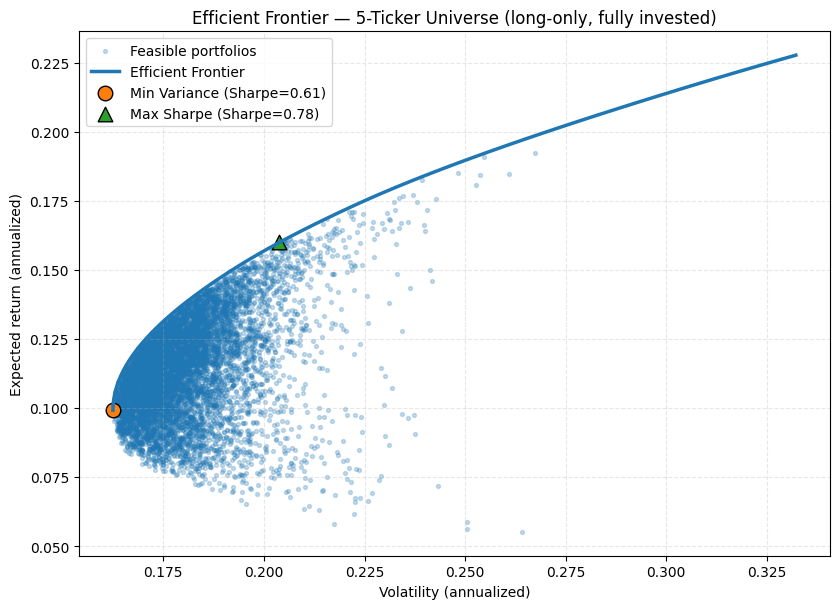

In [52]:
# =================== Step 6: Efficient Frontier Visualization ===================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Expect from Steps 4–5:
# - stats["mu"], stats["cov"], stats["returns"]
# - assets, w_minvar, w_maxshp, port_perf, sharpe_ann (defined in Step 5)
assert 'stats' in globals(), "Step 6 needs 'stats' dict from Step 4."
assert all(k in globals() for k in ['assets','w_minvar','w_maxshp','port_perf','sharpe_ann']), \
       "Step 6 needs results and helpers from Step 5."

mu  = stats["mu"]
cov = stats["cov"]

n_assets = len(assets)
TRADING_DAYS = 252
RF_ANNUAL = 0.00

# ---------- Frontier via optimization (with fallback) ----------
try:
    from scipy.optimize import minimize
    SCIPY_OK = True
except Exception:
    SCIPY_OK = False

bounds = [(0.0, 1.0)] * n_assets
cons_sum = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0}

def min_var_given_return(target_ret: float) -> np.ndarray | None:
    """Solve: minimize w^T Σ w  s.t. sum w=1, w>=0, μ·w = target_ret."""
    if not SCIPY_OK:
        return None
    cons_ret = {'type': 'eq', 'fun': lambda w, tr=target_ret: float(np.dot(mu.values, w)) - tr}
    x0 = np.full(n_assets, 1.0 / n_assets)
    res = minimize(lambda w: float(np.dot(w, np.dot(cov.values, w))),
                   x0=x0, bounds=bounds, constraints=(cons_sum, cons_ret), method='SLSQP')
    return res.x if res.success else None

def efficient_frontier_points(num=50) -> tuple[np.ndarray, np.ndarray, list[np.ndarray]]:
    """
    Return arrays (vols, rets, weights_list) approximating the frontier.
    We sweep target returns between the min-variance return and the max single-asset μ.
    """
    # Return of min-variance (already solved in Step 5)
    r_minvar, _ = port_perf(w_minvar, mu, cov)
    # Upper bound: best single asset by μ (long-only)
    r_max = float(mu.max())

    targets = np.linspace(r_minvar, r_max, num=num)
    vols, rets, W = [], [], []

    for tr in targets:
        w = min_var_given_return(tr)
        if w is None:
            # fallback: random search around simplex to approximate the point
            rng = np.random.default_rng()
            best_w, best_v = None, np.inf
            for _ in range(5000):
                cand = rng.random(n_assets); cand /= cand.sum()
                r, v = port_perf(cand, mu, cov)
                if abs(r - tr) < 1e-3 and v < best_v:
                    best_v, best_w = v, cand
            w = best_w
        if w is not None:
            r, v = port_perf(w, mu, cov)
            rets.append(r); vols.append(v); W.append(w)

    return np.array(vols), np.array(rets), W

# ---------- Random portfolios cloud ----------
def random_portfolios(n_sims=10000, rng_seed=42):
    rng = np.random.default_rng(rng_seed)
    vols = np.empty(n_sims)
    rets_sim = np.empty(n_sims)
    for i in range(n_sims):
        w = rng.random(n_assets); w /= w.sum()
        r, v = port_perf(w, mu, cov)
        vols[i] = v; rets_sim[i] = r
    return vols, rets_sim

# Compute cloud + frontier
cloud_vols, cloud_rets = random_portfolios(n_sims=8000, rng_seed=None)
fr_vols, fr_rets, fr_weights = efficient_frontier_points(num=60)

# Points for our optimal portfolios
r_minvar, v_minvar = port_perf(w_minvar, mu, cov)
r_maxshp, v_maxshp = port_perf(w_maxshp, mu, cov)
s_minvar = sharpe_ann(r_minvar, v_minvar, RF_ANNUAL)
s_maxshp = sharpe_ann(r_maxshp, v_maxshp, RF_ANNUAL)

# ---------- Plot ----------
plt.figure(figsize=(8.5, 6.2))

# Cloud of feasible portfolios
plt.scatter(cloud_vols, cloud_rets, s=8, alpha=0.25, label="Feasible portfolios")

# Efficient frontier curve
if len(fr_vols) > 0:
    order = np.argsort(fr_vols)
    plt.plot(fr_vols[order], fr_rets[order], linewidth=2.5, label="Efficient Frontier")

# Min-variance and Max-Sharpe markers
plt.scatter([v_minvar], [r_minvar], s=110, marker="o", edgecolors="black", linewidths=1.0,
            label=f"Min Variance (Sharpe={s_minvar:.2f})")
plt.scatter([v_maxshp], [r_maxshp], s=110, marker="^", edgecolors="black", linewidths=1.0,
            label=f"Max Sharpe (Sharpe={s_maxshp:.2f})")

plt.xlabel("Volatility (annualized)")
plt.ylabel("Expected return (annualized)")
plt.title("Efficient Frontier — 5-Ticker Universe (long-only, fully invested)")
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## 7. Historical Performance Visualization

Numbers tell us *what* to hold; a time series shows us *how it would have felt*. Here we turn the daily return streams into growth-of-100 curves over the full 5-year window. First we build the three portfolio paths — **Min Variance**, **Max Sharpe**, and a simple **Equal-Weight baseline** — and then we plot them together with the **individual assets** (lighter lines).  

The method mirrors real P&L: we compound the daily portfolio returns into a net asset value (NAV) series. If we computed log-returns earlier, we exponentiate the cumulative sum; if they were simple returns, we use a running product. The portfolio lines are thicker so they stand out against the background of the single-name trajectories.  

This view answers two practical questions at a glance: did the optimized portfolios deliver a smoother ride than the constituents, and how do their long-run outcomes compare? For quick context, we also print a compact table with **CAGR**, **annualized volatility**, and **max drawdown** for each portfolio.

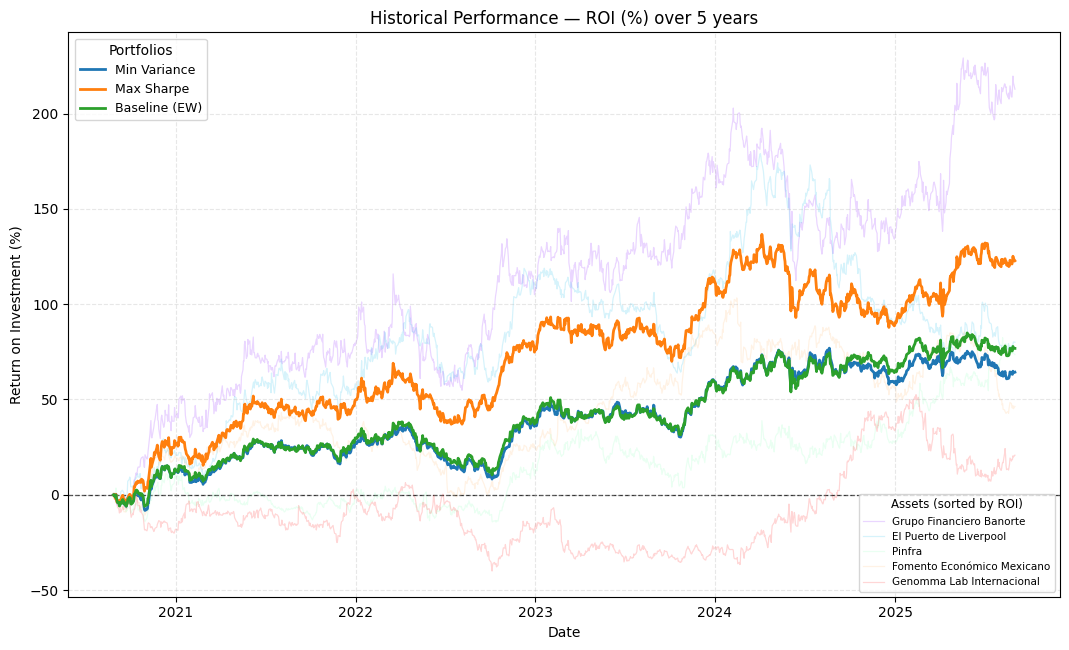

In [57]:
# =================== Step 7: Historical Performance (complete, sorted legend) ===================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Preconditions from Steps 4–5 ---
# rets: DataFrame of daily asset returns (log or simple, consistent)
# assets: list of asset tickers (rets.columns)
# w_minvar, w_maxshp, w_eq: np.array weights for the three portfolios
# RAW: Path to /data/raw (for mapping tickers -> company names)
assert all(k in globals() for k in ['rets','assets','w_minvar','w_maxshp','w_eq','RAW']), \
    "Step 7 needs 'rets', 'assets', 'w_minvar', 'w_maxshp', 'w_eq', and RAW path."

TRADING_DAYS = 252
INITIAL = 100.0

# Detect whether Step 4 used log-returns (you set this there; this is a safe heuristic)
_is_log = rets.abs().median().median() < 0.2

def _portfolio_nav(w: np.ndarray, initial: float = INITIAL) -> pd.Series:
    rp = rets.dot(w)
    if _is_log:
        return initial * np.exp(rp.cumsum())
    else:
        return initial * (1.0 + rp).cumprod()

def _assets_nav(initial: float = INITIAL) -> pd.DataFrame:
    if _is_log:
        return initial * np.exp(rets.cumsum())
    else:
        return initial * (1.0 + rets).cumprod()

# ----- Build NAVs and convert to ROI (%) -----
nav_assets = _assets_nav(INITIAL)
nav_minvar = _portfolio_nav(w_minvar, INITIAL).rename("Min Variance")
nav_maxshp = _portfolio_nav(w_maxshp, INITIAL).rename("Max Sharpe")
nav_eq     = _portfolio_nav(w_eq,     INITIAL).rename("Baseline (EW)")

roi_assets = (nav_assets / INITIAL - 1.0) * 100.0
roi_minvar = (nav_minvar / INITIAL - 1.0) * 100.0
roi_maxshp = (nav_maxshp / INITIAL - 1.0) * 100.0
roi_eq     = (nav_eq     / INITIAL - 1.0) * 100.0

# ----- Map tickers to company names (fallback to ticker if name missing) -----
ticker2name = {}
const_path = RAW / "constituents_with_yahoo.csv"
try:
    if const_path.exists():
        df_const = pd.read_csv(const_path)
        ticker2name = (
            df_const.dropna(subset=["yahoo","name"])
                    .drop_duplicates(subset=["yahoo"])
                    .set_index("yahoo")["name"]
                    .to_dict()
        )
except Exception:
    ticker2name = {}

# ----- Sort assets by final ROI (best → worst) -----
final_rois = roi_assets.iloc[-1].sort_values(ascending=False)
sorted_cols = final_rois.index.tolist()
sorted_labels = [ticker2name.get(t, t) for t in sorted_cols]

# ----- Plot -----
fig, ax = plt.subplots(figsize=(10.8, 6.6))

# Assets: very faint rainbow lines, plotted in sorted order
rainbow = plt.cm.rainbow(np.linspace(0, 1, len(sorted_cols)))
asset_lines = []
for color, col, lbl in zip(rainbow, sorted_cols, sorted_labels):
    ln, = ax.plot(
        roi_assets.index, roi_assets[col],
        linewidth=0.9, alpha=0.16, color=color, label=lbl, zorder=1
    )
    asset_lines.append(ln)

# Portfolios: solid, slightly thicker than assets
ln_min, = ax.plot(roi_minvar.index, roi_minvar.values, linewidth=2.0, label=roi_minvar.name, zorder=5)
ln_max, = ax.plot(roi_maxshp.index, roi_maxshp.values, linewidth=2.0, label=roi_maxshp.name, zorder=5)
ln_eq,  = ax.plot(roi_eq.index,     roi_eq.values,     linewidth=2.0, label=roi_eq.name,  zorder=5)

# Zero baseline (0% ROI): thin dotted line
ax.axhline(0, color="black", linestyle="--", linewidth=0.9, alpha=0.8, zorder=0)

ax.set_title("Historical Performance — ROI (%) over 5 years")
ax.set_xlabel("Date")
ax.set_ylabel("Return on Investment (%)")
ax.grid(True, linestyle="--", alpha=0.3)

# Legends inside the plot
# Portfolios legend (prominent, top-left)
leg_port = ax.legend(
    handles=[ln_min, ln_max, ln_eq],
    loc="upper left", frameon=True, title="Portfolios",
    fontsize=9, title_fontsize=10
)

# Assets legend (sorted by ROI), compact in bottom-right
ncols_assets = 1 if len(asset_lines) <= 6 else 2
leg_assets = ax.legend(
    handles=asset_lines,
    loc="lower right", frameon=True, title="Assets (sorted by ROI)",
    fontsize=7.5, title_fontsize=8.5, ncol=ncols_assets
)
ax.add_artist(leg_port)  # ensure both legends are visible

plt.tight_layout()
plt.show()

# Conclusions and Insights  

This portfolio optimization project has taken us through the full cycle of a real-world investment analysis — from raw data collection to a polished view of portfolio performance. More than just a technical exercise, it demonstrates how financial data science can reveal trade-offs, opportunities, and insights that matter to both investors and decision-makers.  

**Data Foundations and Universes**  
We began by constructing investable universes for the **S&P 500 (U.S.)**, **IPC (Mexico)**, and **Ibovespa (Brazil)**. This step was not trivial: web scraping, cleaning, and mapping tickers to Yahoo Finance symbols revealed the challenges of working with real financial data. The effort paid off by producing consistent datasets across three markets, giving our analysis both local relevance and international scope.  

**Returns, Risk, and Correlation Structure**  
Transforming price histories into returns and covariance matrices brought the statistical structure of each market into view. Correlations across tickers illustrated how diversification can either protect or fail, depending on sectoral overlaps. The logic behind dropping assets with insufficient overlap showed the balance between inclusivity of assets and robustness of estimates.  

**Optimized Allocations**  
The optimization step highlighted the classic dichotomy between **Minimum Variance** and **Maximum Sharpe** portfolios. Both strategies produced allocations that diverge meaningfully from the naive equal-weight baseline. The summary table, enriched with Sharpe, Sortino, and Treynor ratios, grounded the allocations in risk-adjusted performance terms. This is where abstract mean-variance theory became a tangible investment plan.  

**Efficient Frontier**  
The efficient frontier visualization made the trade-offs intuitive. By scattering thousands of simulated portfolios and tracing the upper envelope, we revealed the shape of the opportunity set. Seeing the optimized portfolios sit exactly on the frontier validated the math and showed why these allocations are “efficient choices” in the first place.  

**Historical Performance**  
Numbers became stories once we compounded returns into ROI trajectories. The faint rainbow of assets gave context, while the bold portfolio lines showed how diversification and optimization would have changed the investor’s journey over five years. Ordering the legend by realized ROI made the winners and laggards immediately clear. The dotted zero line provided an anchor: above it is growth, below it is loss. Together, these details created a chart that communicates both intuitively and professionally.  

**Strategic Positioning of the Project**  
Taken as a whole, this project is not only a technical demonstration of financial modeling, but also a showcase of **data storytelling**. It shows the recruiter or stakeholder that we can:  
- Handle messy, real-world financial data.  
- Apply quantitative optimization in a disciplined way.  
- Translate math-heavy results into visual and narrative insights.  
- Produce a polished notebook that reads like both a report and an application.  

**Final Reflection**  
The lesson is that portfolio analysis is not about producing a single “magic allocation.” It is about building the full pipeline — data, cleaning, modeling, visualization, and insight — and showing decision-makers what the trade-offs mean. This notebook proves that technical ability, financial reasoning, and storytelling can merge into a coherent whole. For recruiters, it demonstrates readiness to work on data-driven investment problems with clarity, rigor, and presentation quality.